### Исследование данных по рейтингу производительности процессоров и цен на них.

In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [82]:
df = pd.read_csv('processors.csv', encoding='cp1251', sep=';')
df.head()

,Manufacturer,Model,Rating,Price
0,AMD,EPYC 7763,52987.45,821690.0
1,AMD,Ryzen Threadripper PRO 3995WX,51839.98,558750.0
2,AMD,Ryzen Threadripper 3990X,51279.34,402075.0
3,AMD,EPYC 7713,43915.87,739520.0
4,AMD,EPYC 7662,43208.46,596035.0


In [83]:
df.describe()

,Rating,Price
count,50.000000,50.000000
mean,27432.052600,226328.220000
std,9535.068157,189544.661945
min,16711.820000,42248.000000
25%,19975.300000,84767.750000
50%,24078.575000,181823.000000
75%,32276.315000,272436.250000
max,52987.450000,821690.000000


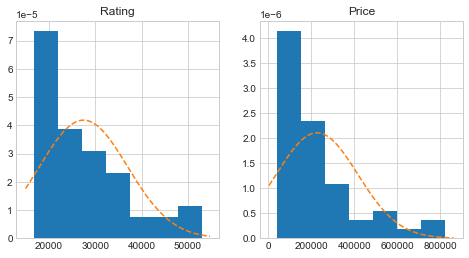

In [84]:
# Построим гистограммы для примерной оценки функции распределения
keys = ['Rating', 'Price']
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(4 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=7)
    loc = df[key].mean()
    scale = df[key].std()
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

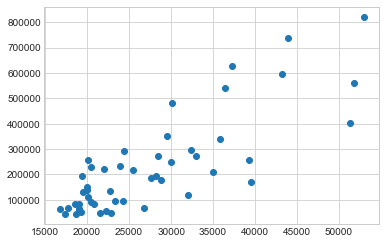

In [85]:
# Построим график рассеивания
plt.style.use('seaborn-whitegrid')
plt.scatter(df['Rating'], df['Price'])

На первый взгляд распределение величин похоже на экспоненциальное

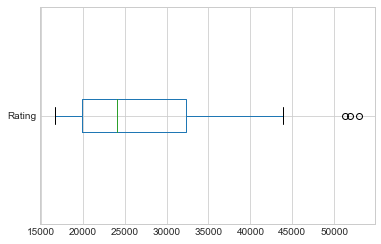

In [86]:
# Посторим Boxplot для рейтинга
df[['Rating']].boxplot(vert=False)
plt.show()

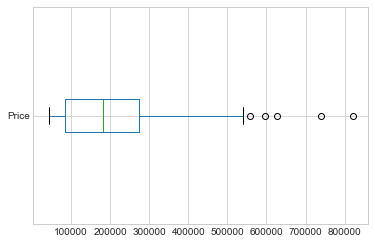

In [87]:
# Посторим Boxplot для цен
df[['Price']].boxplot(vert=False)
plt.show()

In [88]:
# Определим границы boxplota для рейтингов
q1 = df['Rating'].quantile(0.25)
q3 = df['Rating'].quantile(0.75)
iqr = q3 - q1

boxplot_range = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
boxplot_range

(1523.7775000000001, 50727.837499999994)

In [89]:
# Найдем количество и долю выбросов по рейтингам
outliers = df.loc[(df['Rating'] < boxplot_range[0]) | (df['Rating'] > boxplot_range[1])]
outliers.shape[0], outliers.shape[0] / df.shape[0]

(3, 0.06)

In [90]:
# Определим границы boxplota для цен
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1

boxplot_range = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
boxplot_range

(-196735.0, 553939.0)

In [91]:
# Найдем количество и долю выбросов по ценам
outliers = df.loc[(df['Price'] < boxplot_range[0]) | (df['Price'] > boxplot_range[1])]
outliers.shape[0], outliers.shape[0] / df.shape[0]

(5, 0.1)

In [92]:
# Проверяем рейтинг на нормальность
alpha = 0.01

# H0 - распределение нормально
stat, p = stats.normaltest(df['Rating'])
print('Statistics = ', round(stat, 3),  '\tp-value = ', round(p, 3))

Statistics =  11.359 	p-value =  0.003


In [93]:
# Проверяем цены на нормальность
alpha = 0.01

# H0 - распределение нормально
stat, p = stats.normaltest(df['Price'])
print('Statistics = ', round(stat, 3),  '\tp-value = ', round(p, 3))

Statistics =  18.26 	p-value =  0.0


Гипотезу о нормальном распределении величин отвергаем с уровнем ошибки 0.01, т.к. P-value обоих величин существенно меньше alpha. Проверим изначальную гипотезу о том, что величины имеют экспоненциальное распределение.

In [94]:
# Проверяем гипотезу об экспоеннциальном распределении рейтингов
alpha = 0.01

# H0 - распределение экспоненциально
stat, p = stats.expon.fit(df['Rating'])
print('Statistics = ', round(stat, 3),  '\tp-value = ', round(p, 3))

Statistics =  16711.82 	p-value =  10720.233


In [95]:
# Проверяем гипотезу об экспоеннциальном распределении цен
alpha = 0.01

# H0 - распределение экспоненциально
stat, p = stats.expon.fit(df['Price'])
print('Statistics = ', round(stat, 3),  '\tp-value = ', round(p, 3))

Statistics =  42248.0 	p-value =  184080.22


В обоих случаях p-value существенно больше уровня значимости 0.01, поэтому гипотеза от экспоненциальном распределении не отвергается с соотвтествующим уровнем значимости. Но попробуем проверить и другие не нормальные законы распределения.

In [96]:
# Функция определения распределения величин
def get_best_distribution(data):
    dist_names = ['dweibull', 'expon', 'exponweib', 'exponpow', 'genpareto', 'genexpon', 'gausshyper','halfnorm', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'norm', 'pareto', 'pearson3', 't', 'weibull_min', 'weibull_max'] 
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [97]:
get_best_distribution(df['Rating'])

p value for dweibull = 0.20925748064931293
p value for expon = 0.7389303963058766
p value for exponweib = 4.059638190639136e-31
p value for exponpow = 0.6509812766353249
p value for genpareto = 0.766196751253502
p value for genexpon = 0.9053619222671268
p value for gausshyper = 0.6547904394449047
p value for halfnorm = 0.2960370865407871
p value for laplace = 0.06557537528399504
p value for logistic = 0.25116319833602985
p value for loggamma = 0.10681689176358433
p value for loglaplace = 0.2800716844081773
p value for lognorm = 4.971545730989894e-31
p value for lomax = 1.9030336508439636e-07
p value for maxwell = 0.10166252362604733
p value for norm = 0.11792383588691657
p value for pareto = 0.20689377516188223
p value for pearson3 = 0.901916306025183
p value for t = 0.11789933607903624
p value for weibull_min = 5.27173796070099e-35
p value for weibull_max = 3.5844516414412845e-36
Best fitting distribution: genexpon
Best p value: 0.9053619222671268
Parameters for the best fit: (0.40696

('genexpon',
 0.9053619222671268,
 (0.40696180350275335,
  3.2946154317583094,
  0.011758858761911004,
  16709.753058520375,
  5128.51536932069))

Рейтинг процессоров распределен по обобщенному экспоненциальному закону распределения непрерывных случайных величин

In [98]:
get_best_distribution(df['Price'])

p value for dweibull = 0.05961717023225921
p value for expon = 0.8469326811646917
p value for exponweib = 0.729453085390573
p value for exponpow = 0.9582433183977335
p value for genpareto = 0.7701827818143586
p value for genexpon = 0.9486967559943063
p value for gausshyper = 0.41503689043933856
p value for halfnorm = 0.08063749959310751
p value for laplace = 0.07429570592072166
p value for logistic = 0.09527045526959932
p value for loggamma = 0.08814963453814462
p value for loglaplace = 0.295415678431294
p value for lognorm = 1.655014790016294e-28
p value for lomax = 0.8761682885876007
p value for maxwell = 0.21012564069390038
p value for norm = 0.12407186526720604
p value for pareto = 0.06315402511094503
p value for pearson3 = 0.41749726486670913
p value for t = 0.08145406445138559
p value for weibull_min = 0.9705331218942248
p value for weibull_max = 2.969062885762455e-39
Best fitting distribution: weibull_min
Best p value: 0.9705331218942248
Parameters for the best fit: (0.934173798

('weibull_min',
 0.9705331218942248,
 (0.9341737982630365, 42247.99999999999, 174585.51617723968))

Цены на процессоры по своему распределению ближе к закону распределения минимальных экстремальных значений случайных величин Вейбулла.

In [99]:
# Проверим корреляцию по методу Кендалла
df.corr(method='kendall')

,Rating,Price
Rating,1.000000,0.584729
Price,0.584729,1.000000


In [100]:
# Проверим корреляцию по методу Спирмана
df.corr(method='spearman')

,Rating,Price
Rating,1.00000,0.77721
Price,0.77721,1.00000


Величины имеют достаточно высокую корреляцию

In [101]:
x1 = df.Rating
y1 = df.Price

In [102]:
x1.shape, y1.shape

((50,), (50,))

In [103]:
# Найдем коэффициенты линейной регрессии.
b1 = (np.mean(x1 * y1) - np.mean(x1) * np.mean(y1)) / (np.mean(x1 ** 2) - np.mean(x1) ** 2)
b0 = np.mean(y1) - b1 * np.mean(x1)

b0, b1

(-218640.60043793052, 16.22076287641453)

Модель линейной регрессии имеет вид:
$$y = -218640.60 + 16.22 \cdot x,$$ 
т.е. с увеличением производительности на 1 пункт цена на процессор возрастает на  16.22 рубля.

Для проверки найдем коэффициенты методом наименьших квадратов

In [104]:
x1.shape, y1.shape

((50,), (50,))

In [105]:
ones = np.ones((x1.shape[0], 1)).T
x2 = np.vstack([ones, x1]).T
x2.shape

(50, 2)

In [106]:
XTX = x2.T.dot(x2)
np.linalg.det(XTX)

222747935639.30856

Определиетль не близок к 0, можно искать коэффициенты

In [107]:
XTX_inv = np.linalg.inv(XTX)
b = XTX_inv.dot(x2.T).dot(y1)
b

array([-2.18640600e+05,  1.62207629e+01])

In [108]:
b0, b[0], b1, b[1]

(-218640.60043793052,
 -218640.60043793183,
 16.22076287641453,
 16.220762876414575)

Полученные разными методами коэффициенты максимально близки

Визуализируем даные

In [109]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

Text(0, 0.5, 'цена')

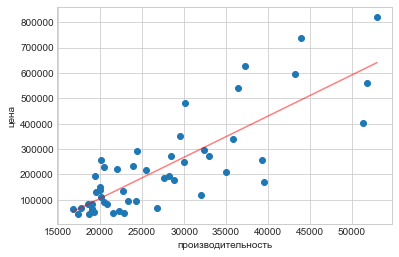

In [110]:
ox = x1
oy = b0 + b1 * ox

plt.scatter(x1, y1)
plt.plot(ox, oy, color='red', alpha=0.5)

plt.xlabel('производительность')
plt.ylabel('цена')

Посчитаем коэффициент детерминации

In [111]:
def sum_of_squares(samples):
    return ((samples - samples.mean()) ** 2).sum()

In [112]:
z1 = b0 + b1 * x1

In [113]:
R1 = 1 - ((y1 - z1)**2).sum() / sum_of_squares(y1)
R1

0.6658356409616176

Модель объясняет 66% дисперсии

Оценим построенное уравнение регрессии с помощью F-критерия Фишера

In [114]:
n = x1.shape[0]
m = 1

k1 = m
k2 = n - m - 1

k1, k2

(1, 48)

In [115]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

4.042652128566653

Критическая область:
$$\Omega_\alpha = \left( 4.04, \infty \right)$$

In [116]:
F = (R1 / k1) / ((1 - R1) / k2)
F

95.64188969203231

Статистика попала в критическую область, уравнение регрессии признаётся значимым.

Посчитаем среднюю ошибку аппроксимации

In [117]:
def mean_approximation_error(y_real, y_pred):
    return np.abs((y_real - y_pred) / y_real).mean()

In [118]:
mean_approximation_error(y1, z1)

0.5021678624989988

Значение средней ошибки аппроксимации более 50% - модель линейной регрессии выдает значения очень отдаленные от реальных данных.

#### Проверим зависимость цены от производительностиотдельно по AMD и Intel

In [119]:
amd = df[df['Manufacturer'] == 'AMD']
intel = df[df['Manufacturer'] == 'Intel']
amd.shape, intel.shape

((35, 4), (15, 4))

In [120]:
x1 = amd.Rating
y1 = amd.Price
x2 = intel.Rating
y2 = intel.Price

In [121]:
# Найдем коэффициенты линейной регрессии.
b11 = (np.mean(x1 * y1) - np.mean(x1) * np.mean(y1)) / (np.mean(x1 ** 2) - np.mean(x1) ** 2)
b01 = np.mean(y1) - b11 * np.mean(x1)
b12 = (np.mean(x2 * y2) - np.mean(x2) * np.mean(y2)) / (np.mean(x2 ** 2) - np.mean(x2) ** 2)
b02 = np.mean(y2) - b12 * np.mean(x2)

print(f'  AMD - b0: {b01} b1: {b11}')
print(f'Intel - b0: {b02} b1: {b12}')

  AMD - b0: -256692.83877760576 b1: 17.232290103369273
Intel - b0: -104121.06313612513 b1: 11.853734564985004


In [122]:
z1 = b01 + b11 * x1
z2 = b02 + b12 * x2

In [123]:
R1 = 1 - ((y1 - z1)**2).sum() / sum_of_squares(y1)
R2 = 1 - ((y2 - z2)**2).sum() / sum_of_squares(y2)
R1, R2

(0.6625269802012514, 0.5164809726746912)

Модель объясняет 66% дисперсии по процессорам AMD и 51% по процессорам Intel

Посчитаем среднюю ошибку аппроксимации

In [124]:
mean_approximation_error(y1, z1)

0.5318360724364977

In [125]:
mean_approximation_error(y2, z2)

0.3501348236391936

Значение средней ошибки аппроксимации по процессорам AMD более 53%, по Intel - 35%. Модель линейной регрессии при разделении по производителям также выдает значения очень отдаленные от реальных данных, но по процессорам Intel немного ближе к фактическим.

В целом, очевидно, что на цену процессора влияет не только его производительность. На нее оказывает влияние большое количество факторов и построить модель, которая будет выдавать расчетные значения близкие к реальным затруднительно, к тому же выборка и сама генеральная совокупность не очень большие.

#### Проведем дисперсионный анализ по производительности и ценам на прицессоры AMD и Intel

Выдвинем гепотезы, что средняя производительность и средняя цена у обоих производителей процессоров одинакова

In [156]:
y1 = amd.Price
y2 = intel.Price

y3 = amd.Rating
y4 = intel.Rating

n1 = y1.shape[0]
n2 = y2.shape[0]
n3 = y3.shape[0]
n4 = y4.shape[0]

n12 = n1 + n2
n34 = n3 + n4

In [134]:
y1_mean = y1.mean()
y2_mean = y2.mean()
y3_mean = y3.mean()
y4_mean = y4.mean()
y1_mean, y2_mean, y3_mean, y4_mean

(256282.85714285713,
 156434.06666666668,
 29768.283428571423,
 21980.847333333335)

In [135]:
y_1 = np.concatenate([y1, y2])
y_2 = np.concatenate([y3, y4])

In [138]:
y_1_mean = y_1.mean()
y_2_mean = y_2.mean()
y_1_mean, y_2_mean

(226328.22, 27432.052600000003)

Найдём значения $S_b$ и $S_{w}$:

In [137]:
# По ценам на процессоры
S2_b1 = n1 * (y1_mean - y_1_mean) ** 2 + n2 * (y2_mean - y_1_mean) ** 2
S2_w1 = ((y1 - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum()

S2_b1, S2_w1

(104682700075.36092, 1655749064651.219)

In [139]:
# По рейтингу произвоодительности процессоров
S2_b2 = n3 * (y3_mean - y_2_mean) ** 2 + n4 * (y4_mean - y_2_mean) ** 2
S2_w2 = ((y3 - y3_mean) ** 2).sum() + ((y4 - y4_mean) ** 2).sum()

S2_b2, S2_w2

(636763689.842879, 3818195022.943282)

Проверим выполнение равенства $S^2 = S_b^2 + S_{w}^2:$

In [154]:
round(S2_b1 + S2_w1, 3) == round(((y_1 - y_1_mean) ** 2).sum(), 3)

True

In [153]:
round(S2_b2 + S2_w2, 3) == round(((y_2 - y_2_mean) ** 2).sum(), 3)

True

In [165]:
# Найдем оценки дисперсий
k = 2
k1 = k - 1
k2 = n12 - k

k3 = k1
k4 = n34 - k

sigma2_b1 = S2_b1 / k1
sigma2_w1 = S2_w1 / k2

sigma2_b2 = S2_b2 / k3
sigma2_w2 = S2_w2 / k4

sigma2_b1, sigma2_w1, sigma2_b2, sigma2_w2

(104682700075.36092, 34494772180.23373, 636763689.842879, 79545729.64465171)

Найдем значение статистики $T$:

In [163]:
T1 = sigma2_b1 / sigma2_w1
T2 = sigma2_b2 / sigma2_w2
T1, T2

(3.034741018969432, 8.005001559322451)

Зафиксируем уровень значимости $\alpha = 0.05$. Для него найдём критическое значение $F_{crit}$:

In [164]:
alpha = 0.05

F_crit1 = stats.f.ppf(1 - alpha, k1, k2)
F_crit2 = stats.f.ppf(1 - alpha, k3, k4)
F_crit1, F_crit2

(4.042652128566653, 4.042652128566653)

Найдем p-value

In [167]:
p1 = 1 - stats.f.cdf(T1, k1, k2)
p2 = 1 - stats.f.cdf(T2, k3, k4)
p1, p2

(0.08790461947231643, 0.0067896260850813794)

Проверим встроенными методами

In [174]:
from scipy.stats import f_oneway
stat1 = f_oneway(y1, y2)

In [175]:
stat2 = f_oneway(y3, y4)

In [177]:
print(p1, p2)
print(stst1[1], stst2[1])

0.08790461947231643 0.0067896260850813794
0.08790461947231641 0.006789626085081314


Значения p-value, рассчитанные разными методами получились максимально близкими.

Гипотеза о равности средних цен процессоров у производителей AMD и Intel не отвергается с уровнем значимости 0.05, т.к. p-value1 = 0,08.
Гипотеза о равности средней производительности процессоров у производителей AMD и Intel отвергается с вероятностью ошибки 0,05, т.к. p-value2 = 0,006.